In [1]:
import numpy as np
import os
import torch
import pandas as pd 
from arguments import parser
from torch.utils.data import DataLoader

from train import refinement_run
from datasets import create_dataset
from utils.log import setup_default_logging

from accelerate import Accelerator
from omegaconf import OmegaConf

from torch.distributed import get_rank
torch.autograd.set_detect_anomaly(True)

import matplotlib.pyplot as plt 
from utils.utils import * 

import cv2 
def img_postprocess(img):
    img = torch.permute(img, dims=(1,2,0)).detach().cpu().numpy()
    img = normalizing(img)
    img = np.uint8(255*img)[:,:,::-1]
    return img 

def sm_postprocess(sm):
    sm = torch.permute(sm.detach().cpu(),dims=(1,2,0)).numpy()
    sm = normalizing(sm)
    sm = cv2.applyColorMap(np.uint8(255*sm), cv2.COLORMAP_JET)
    return sm 



def data_setting(cfg):
    trainset, testset = create_dataset(
        dataset_name  = cfg.DATASET.dataset_name,
        datadir       = cfg.DATASET.datadir,
        class_name    = cfg.DATASET.class_name,
        img_size      = cfg.DATASET.img_size,
        mean          = cfg.DATASET.mean,
        std           = cfg.DATASET.std,
        aug_info      = cfg.DATASET.aug_info,
        **cfg.DATASET.get('params',{})
    )

    # define test dataloader
    testloader = DataLoader(
        dataset     = testset,
        batch_size  = 64,
        shuffle     = False,
        num_workers = 8
    )
    
    return testloader 


def get_model(weight_dir,model):
    weight = torch.load(weight_dir)
    model.load_state_dict(weight)    
    return model 

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 기본 시각화 

FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


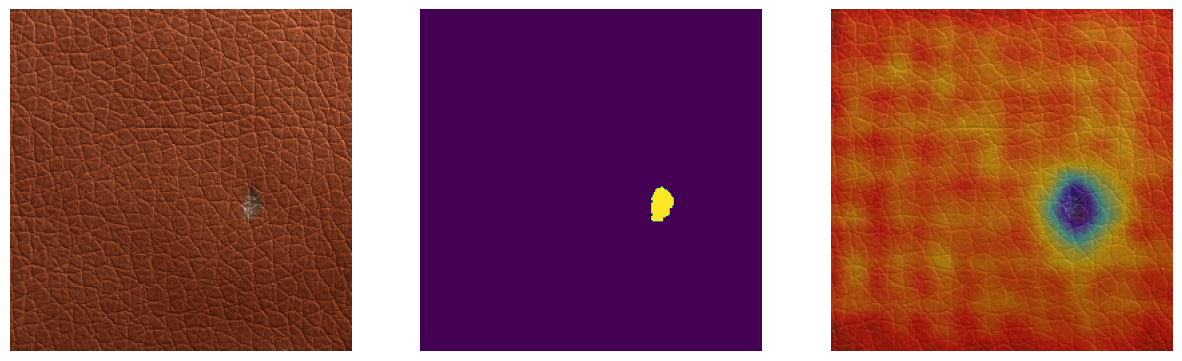

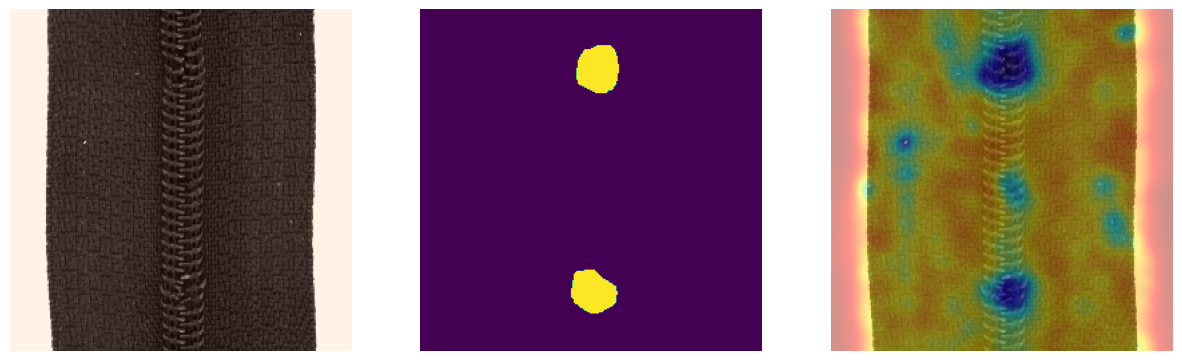

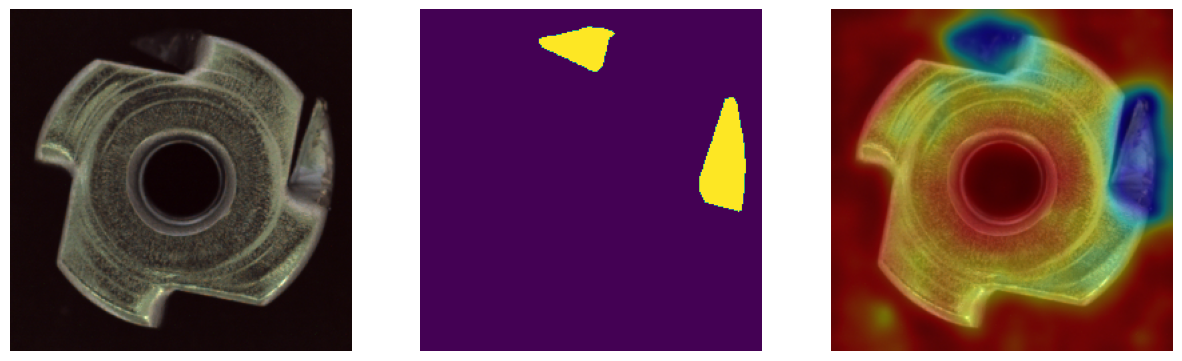

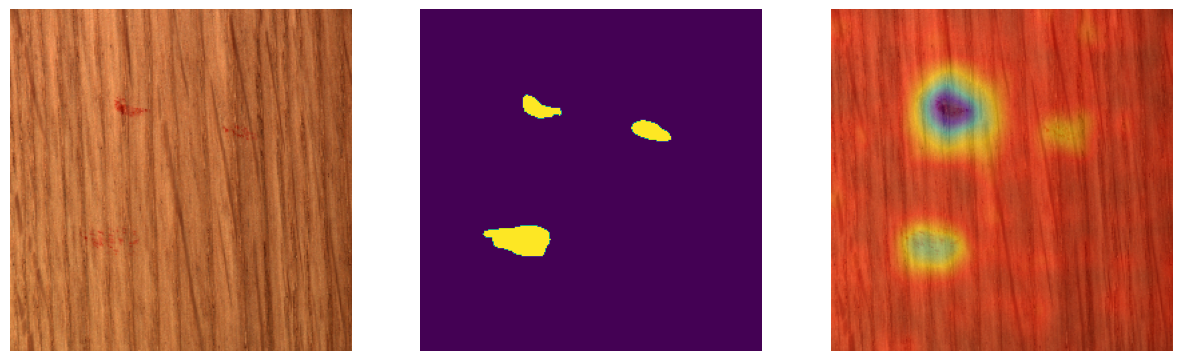

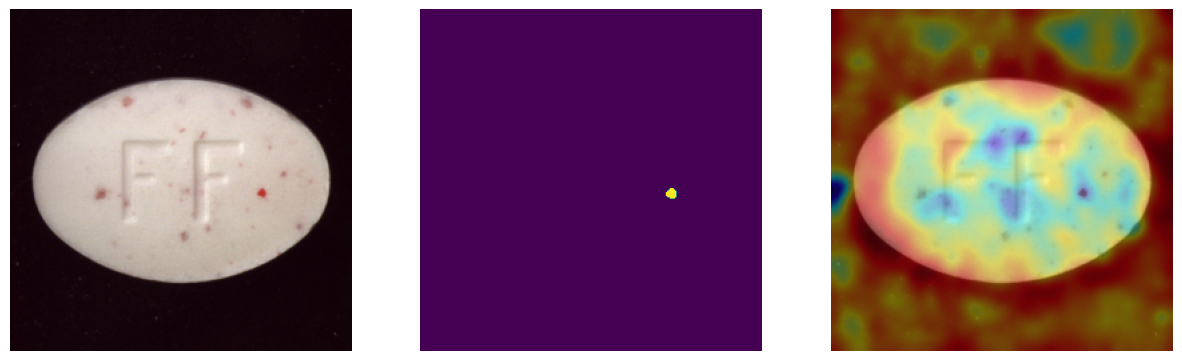

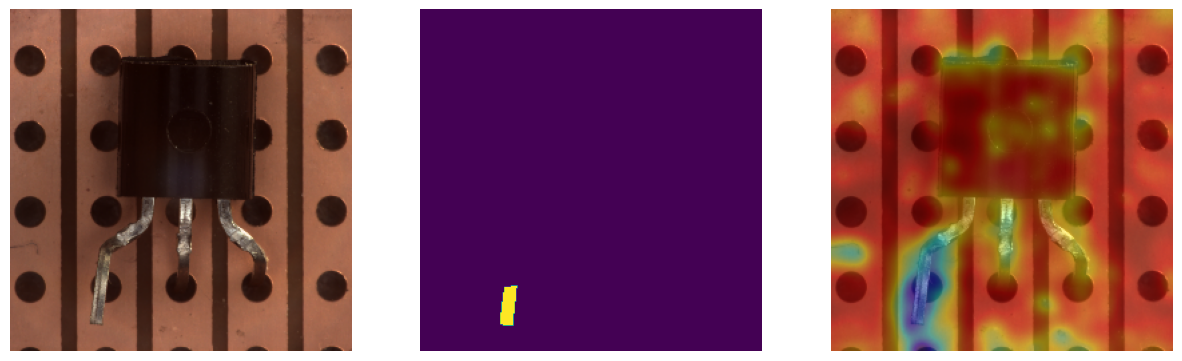

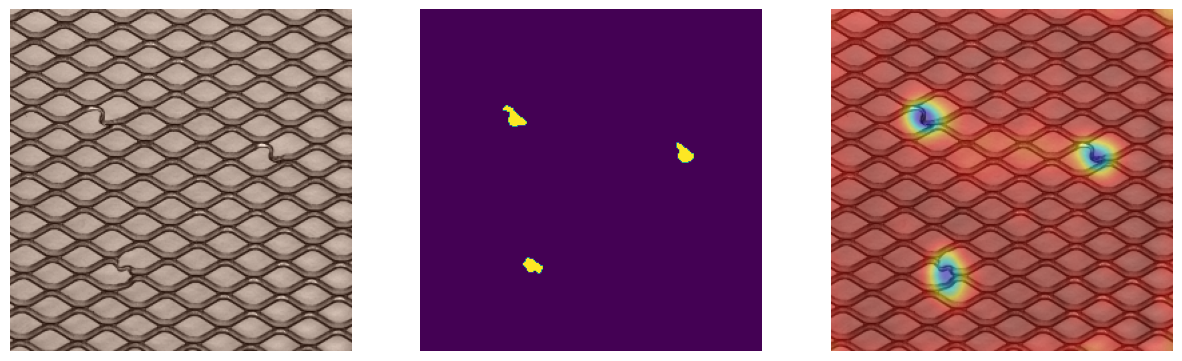

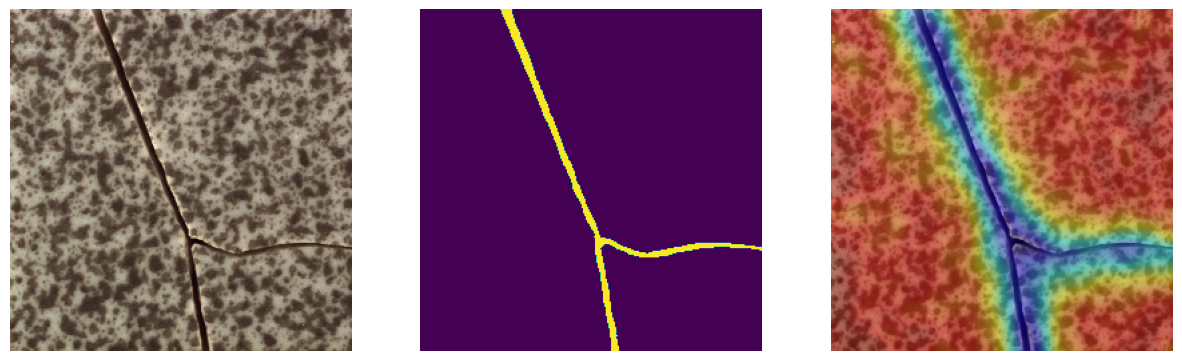

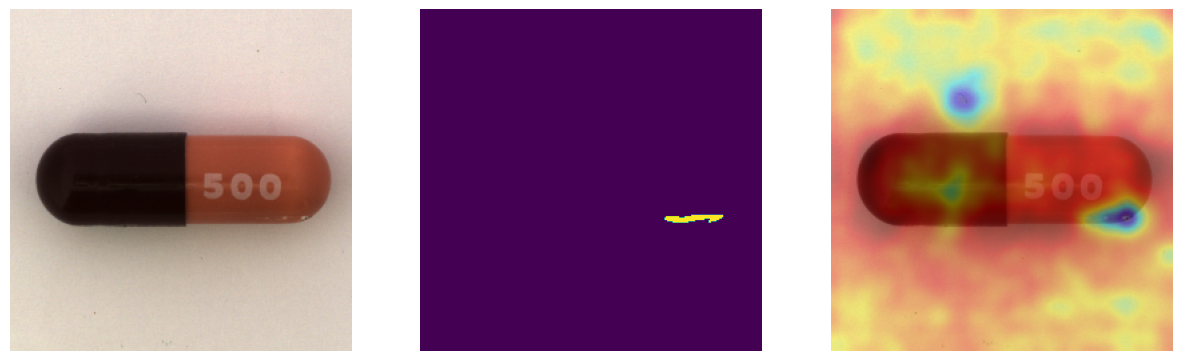

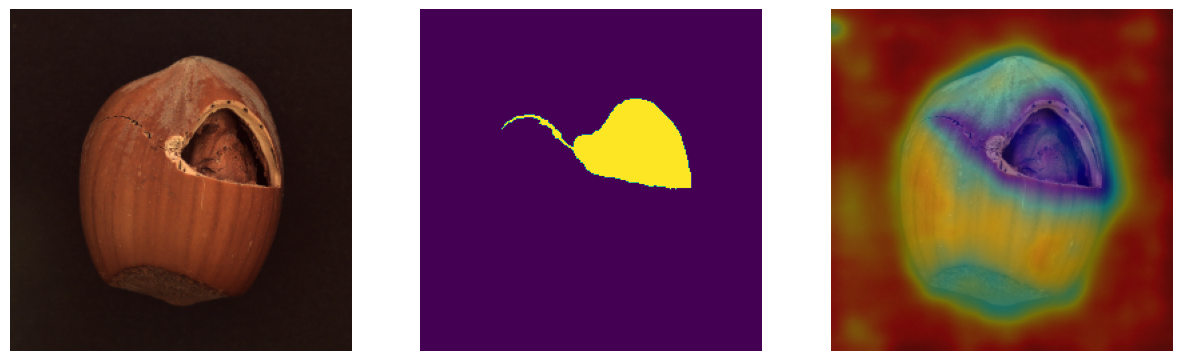

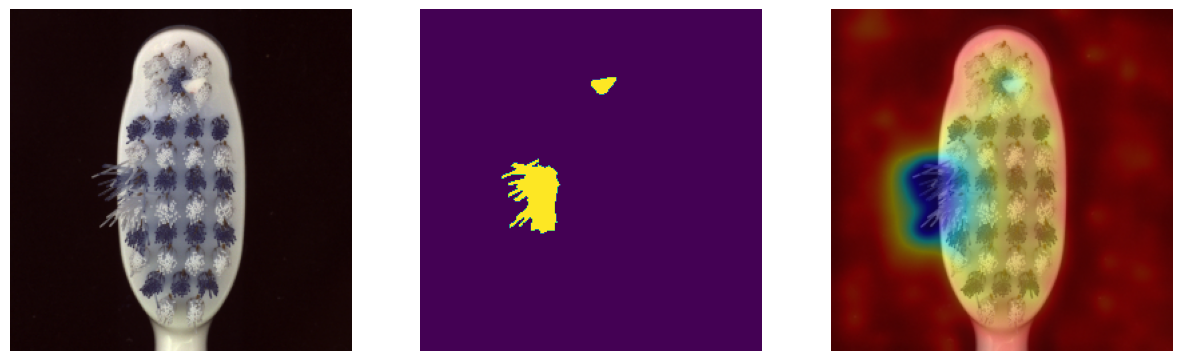

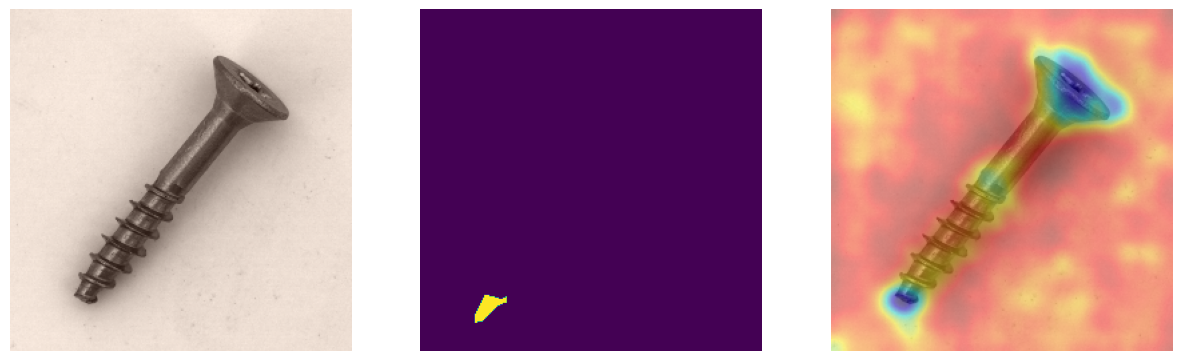

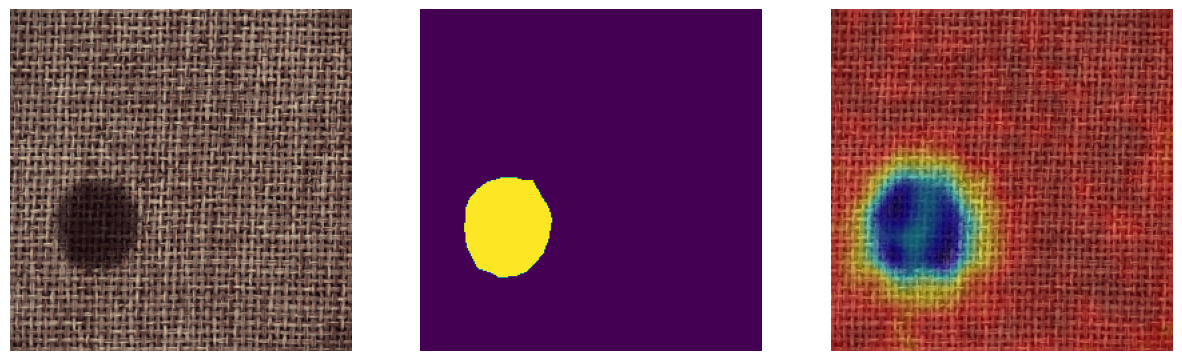

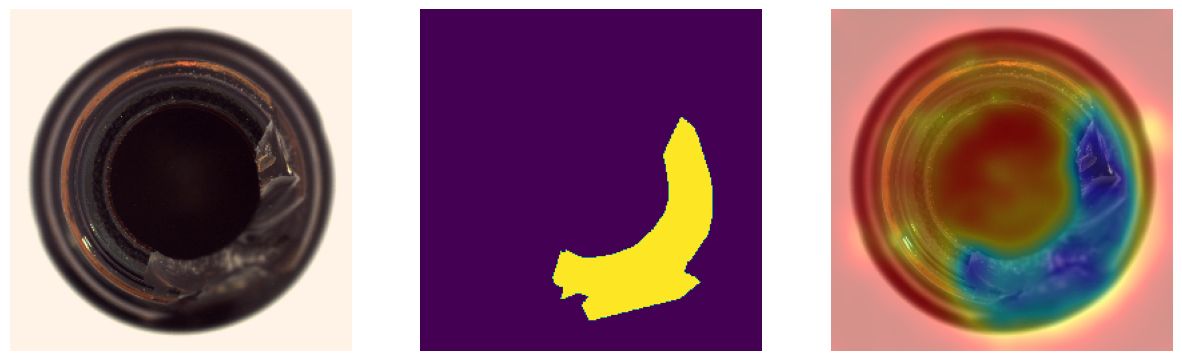

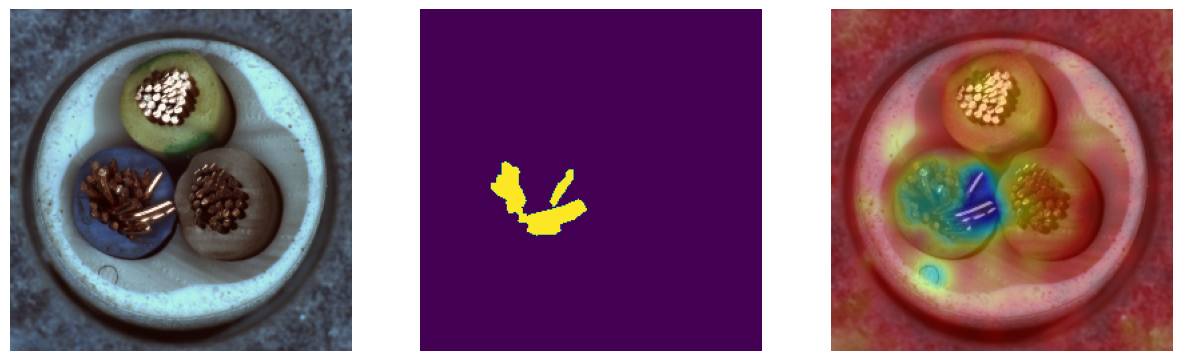

In [ ]:
import os 
from glob import glob 
import yaml 
from easydict import EasyDict
from arguments import parser
import copy 
from utils.utils import * 

mother_path = 'results'
dataset = 'MVTecAD'
method = 'ReverseDistillation'
class_name = '*'
exp_name = 'dataset_fix-anomaly_ratio_0.1'
seed = 42
hue = 'class_name'
device = 'cuda'

default_setting = './configs/benchmark/rd_mvtecad.yaml'
cfg = parser(jupyter=True, default_setting = default_setting)

weight_dirs = glob(os.path.join(mother_path, dataset, method, class_name, exp_name, f"seed_{seed}", 'model_best.pt'))
cfg_dirs = glob(os.path.join(mother_path, dataset, method, class_name, exp_name, f"seed_{seed}", 'configs.yaml'))

model = __import__('models').__dict__[method](
        backbone = cfg['MODEL']['backbone'],
        **cfg['MODEL']['params']
        )

for weight_dir, cfg_dir in zip(weight_dirs, cfg_dirs):
    
    cfg = yaml.load(open(cfg_dir),Loader=yaml.Loader)
    cfg = EasyDict(cfg)
    
    
    trained_model = get_model(weight_dir, copy.deepcopy(model)).to(device)
    testloader = data_setting(cfg)
    
    imgs, labels, gts = (next(iter(testloader)))
    imgs = imgs.to(device)
    
    with torch.no_grad():
        output = trained_model(imgs)
        sms = model.get_score_map(output)
        
    sm = sm_postprocess(sms[torch.argmax(labels).item()])
    img = img_postprocess(imgs[torch.argmax(labels).item()])
    gt = img_postprocess(gts[torch.argmax(labels).item()])
    
    result = cv2.addWeighted(img, 0.6, sm, 0.4, 0)
    
    fig,axes = plt.subplots(1,3,figsize=(15,5))
    
    axes[0].imshow(img)    
    axes[0].axis('off')
    axes[1].imshow(gt)
    axes[1].axis('off')
    axes[2].imshow(result)
    axes[2].axis('off')
    
    plt.show()
    
    del trained_model
    